In [516]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [517]:
data = pd.read_excel('Indicadores.xlsx')
data = data.sort_values(by='Periodo')
data = data.reset_index(drop=True)

In [518]:
data.index = pd.to_datetime(data['Periodo'])
data.drop(columns='Periodo',inplace=True)
data.head()
data

,Valor
Periodo,
1993-01-01,60.407691
1993-02-01,61.022521
1993-03-01,63.943249
1993-04-01,61.865984
1993-05-01,63.612900
...,...
2022-03-01,111.940152
2022-04-01,109.529866
2022-05-01,114.442424


<AxesSubplot:xlabel='Periodo'>

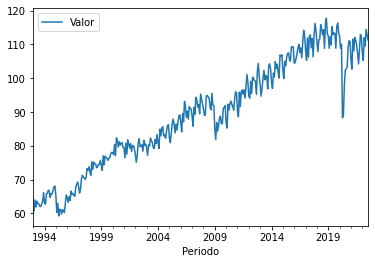

In [519]:
data.plot()

Notamos que al graficar la serie se muestra una tendencia, por lo que podemos afirmar que esta serie en non-stationary.

In [520]:
def check_for_stationary(data):
	#X = data['Valor'].values
	X = data.values
	result = adfuller(X)
	if result[1] <= 0.05:
		print('the variable is stationary')
	else:
		print('the variable is non starionary')
	print('p_value: '+ str(result[1]))
	return

In [521]:
check_for_stationary(data['Valor'])

the variable is non starionary
p_value: 0.7848372900898417


In [522]:
an_change = np.log(data['Valor']) - np.log(data['Valor'].shift(12))
an_change = an_change.dropna()
check_for_stationary(an_change)

the variable is stationary
p_value: 0.0032602635688593956


hasta el momento:
- D = 1
- d = 0

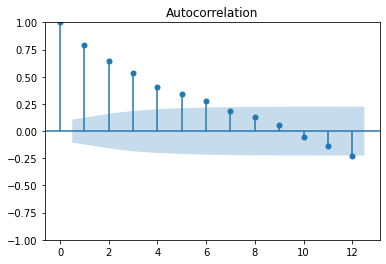

In [523]:
sm.graphics.tsa.plot_acf(an_change.values.squeeze(), lags=12)
plt.show()

Las primeras 7 correlaciones entre la serie y los lags son positivas y significativos y luego va decayendo. Esto nos dice que el crecimiento anual de la economia es sumamente influido por el crecimiento anual del mes pasado. Pasa lo mismo con los primero 7 meses.


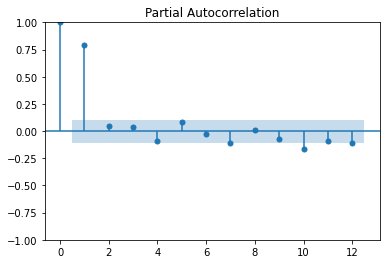

In [524]:
sm.graphics.tsa.plot_pacf(an_change.values.squeeze(), lags=12, method="ywm")
plt.show()

Nota: pacf muestra la autocorrelacion parcial entre la serie y los lags

La grafica ACF muestra un decaimiento lento, mientras que la pacf muestra uno muy rapido (inicia con autocorrelacion muy alta en los primeros 2 lags y luego baja hasta cero y negativos). Esto nos dice que el modelo es un AR. 

Determinar la cantidad de AR (p):
- Se determina a partir de los lags significativos en el PACF 
- p=2    q=0

D y d: 
- Debido a que estoy modelando la diferencia de seasonal (crecimiento anual) tenemos un D=1 y d=0 porque solo se necesitó sacar la 1era diferencia seasonal para volver "stationary" nuestro modelo.

P y Q = 0

we are modelling the seasonal difference of the log, which is the ANNUAL % GROWTH of passengers month by month.

In [ ]:
model = SARIMAX(np.log(data['Valor']), order=(2,0,0),seasonal_order =(0,1,0,12),trend='c',simple_differencing=True)
history = model.fit()
history.summary()


El crecimiento anual del mes pasado impacta en un 75% al crecimiento anual en este mes. El crecimiento anual de hace 2 meses casi no tiene impacto en el crecimiento anual en este mes, ya que solo se relacionan en un 4%.
Dicho de otro modo, por cada porciento del crecimiento anual del mes anterior, se espera que el crecimiento anual de este mes crezca un 75%

El drift es positivo y muy significativo en el modelo, por lo que se puede notar que el valor crezca con el tiempo

Ahora quiero conocer los residuales del modelo, para saber si aun hay algo que se puede tomar en consideración dentro del modelo para mejorar su desempeño. 

aic = -1476.067421768414


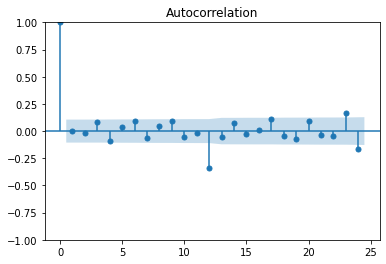

In [526]:
residuals = history.resid
print("aic = "+ str(history.aic))
sm.graphics.tsa.plot_acf(residuals.squeeze(),lags=24)
plt.show()

Es claro que aun hay algo que no se está tomando en cuenta en el modelo, y gracias a la gráfica puedo ver que hay un pico en el lag 12, por lo que debería aumentar un término seasonal anual al modelo

In [ ]:
model2 = SARIMAX(np.log(data['Valor']), order=(2,0,0),seasonal_order =(0,1,1,12),trend='c',simple_differencing=True)
history2 = model2.fit()


aic = -1607.2398981703384


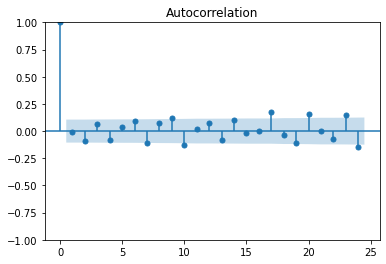

In [528]:
residuals2 = history2.resid
print("aic = "+ str(history2.aic))
sm.graphics.tsa.plot_acf(residuals2.squeeze(),lags=24)
plt.show()

Si volvemos a ver los residuales notamos que el pico ha desaparecido, lo cual significa que hemos logrado ajustar el modelo

In [529]:
history2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           DS12.Valor   No. Observations:                  343
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 12)   Log Likelihood                 808.620
Date:                              Mon, 24 Oct 2022   AIC                          -1607.240
Time:                                      23:13:34   BIC                          -1588.051
Sample:                                  01-01-1994   HQIC                         -1599.596
                                       - 07-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0022      0.000      5.003      0.000       0.001       0.003
ar.L1          0.7578      0.028     26.911      0.000       0.703       0.813
ar.L2          0.1337      0.034      3.901      0.000       0.066       0.201
ma.S.L12      -0.8387      0.046    -18.160      0.000      -0.929      -0.748
sigma2         0.0005   1.35e-05     37.468      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):              9672.55
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                            -2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Coeficientes:
- drift: es sumamente significativo (z = -4.368) y está relacionado con el crecimiento económico anual en un -0.22% 
- phi 1: tiene alta significancia en el modelo (z=22.477) y está relacionado con el crecimiento económico anual en un 76% , lo que significa que el 76% del crecimiento anual se puede explicar gracias a este coeficiente
- phi 2: tiene alta significancia en el modelo (z=3.611) y está relacionado con el crecimiento económico anual en un 12% , lo que significa que el 12% del crecimiento anual se puede explicar gracias a este coeficiente

## Predicciones

In [530]:
data.shape
len(data)

355

In [ ]:
modelFinal = SARIMAX(data['Valor'], order=(2,0,0),seasonal_order =(0,1,1,12),trend='c',simple_differencing=True)
historyFinal = modelFinal.fit()

pred = historyFinal.predict(start =0 , end =400, dynamic=True)

<AxesSubplot:xlabel='Periodo'>

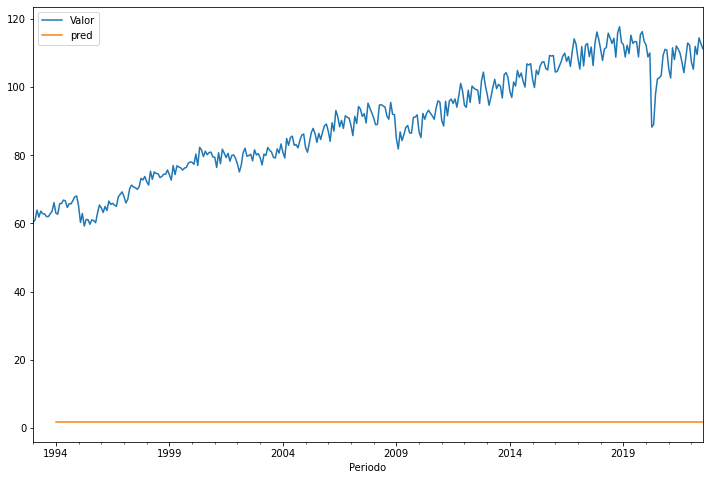

In [532]:
data['pred'] = historyFinal.predict(start =0 , end =400, dynamic=True)
data[['Valor','pred']].plot(figsize=(12,8))

In [533]:
#Hacer un nuevo dataset vacio para hacer predicciones a futuro
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1] + DateOffset(months=x)for x in range(0,24)]

# columnas del nuevo dataset
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

data=pd.concat([data,pred_date])

<AxesSubplot:>

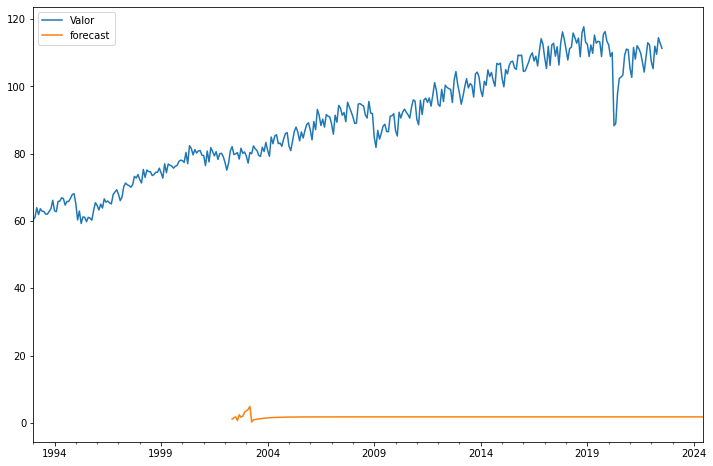

In [534]:
data['forecast'] = historyFinal.predict(start = 100, end = 370, dynamic= True)  
data[['Valor', 'forecast']].plot(figsize=(12, 8))

In [535]:
data.head()

,Valor,pred,forecast
1993-01-01,60.407691,NaN,NaN
1993-02-01,61.022521,NaN,NaN
1993-03-01,63.943249,NaN,NaN
1993-04-01,61.865984,NaN,NaN
1993-05-01,63.612900,NaN,NaN


In [536]:
#https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
#https://rpubs.com/cdorante/ec2004_w4